In [ ]:
!pip install keras


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset

df = pd.read_csv("TASK-ML-INTERN.csv")

df_processed = df.drop(columns=['hsi_id'])

X = df_processed.drop(columns=['vomitoxin_ppb'])
y = df_processed['vomitoxin_ppb']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




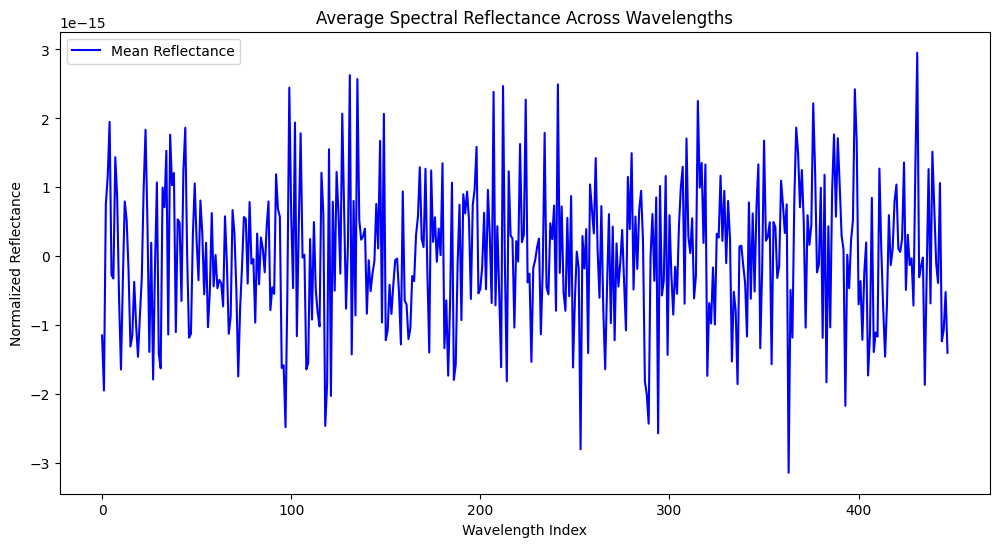

In [ ]:
# --- Data Visualization ---

mean_spectrum = np.mean(X_scaled, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(range(X.shape[1]), mean_spectrum, label="Mean Reflectance", color='b')
plt.xlabel("Wavelength Index")
plt.ylabel("Normalized Reflectance")
plt.title("Average Spectral Reflectance Across Wavelengths")
plt.legend()
plt.show()



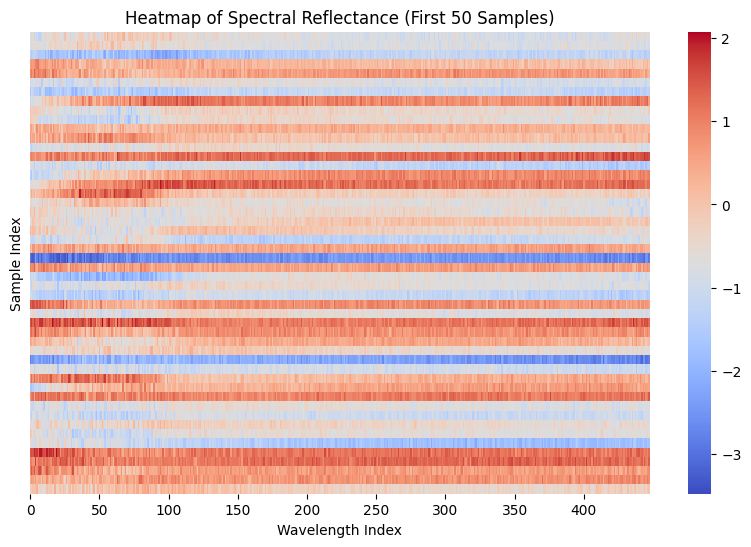

In [ ]:
# Heatmap of spectral reflectance for first 50 samples
plt.figure(figsize=(10, 6))
sns.heatmap(X_scaled[:50, :], cmap="coolwarm", xticklabels=50, yticklabels=False)
plt.xlabel("Wavelength Index")
plt.ylabel("Sample Index")
plt.title("Heatmap of Spectral Reflectance (First 50 Samples)")
plt.show()



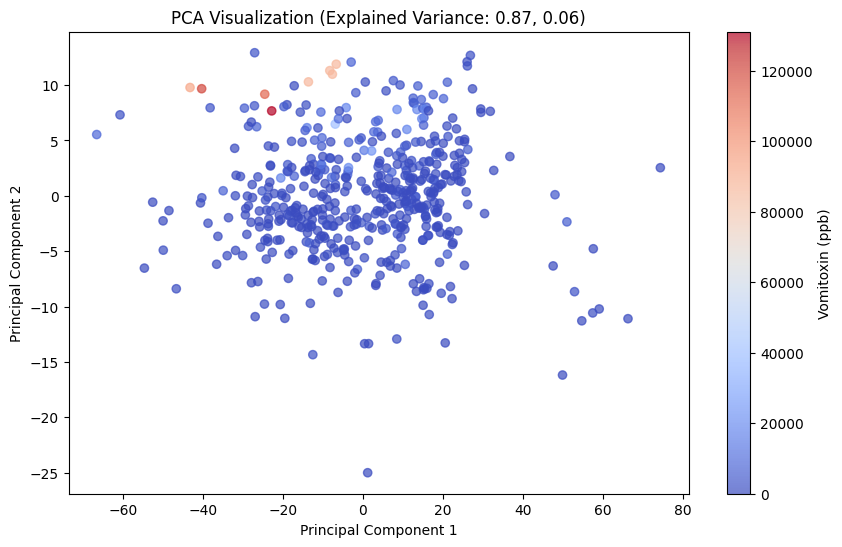

Explained Variance: [0.87077909 0.05849069]


In [ ]:
# --- PCA for Dimensionality Reduction ---

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Vomitoxin (ppb)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Visualization (Explained Variance: {explained_variance[0]:.2f}, {explained_variance[1]:.2f})')
plt.show()

print(f"Explained Variance: {explained_variance[:2]}")



In [ ]:
# --- Model Training ---


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 2. Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 3. Train Neural Network
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)
y_pred_nn = nn_model.predict(X_test).flatten()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
# --- Model Evaluation ---

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nModel: {model_name}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")


evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_nn, "Neural Network")




Model: Random Forest
MAE: 3765.06
RMSE: 11483.81
R² Score: 0.5282

Model: XGBoost
MAE: 3972.93
RMSE: 12996.29
R² Score: 0.3958

Model: Neural Network
MAE: 3323.55
RMSE: 10029.55
R² Score: 0.6401


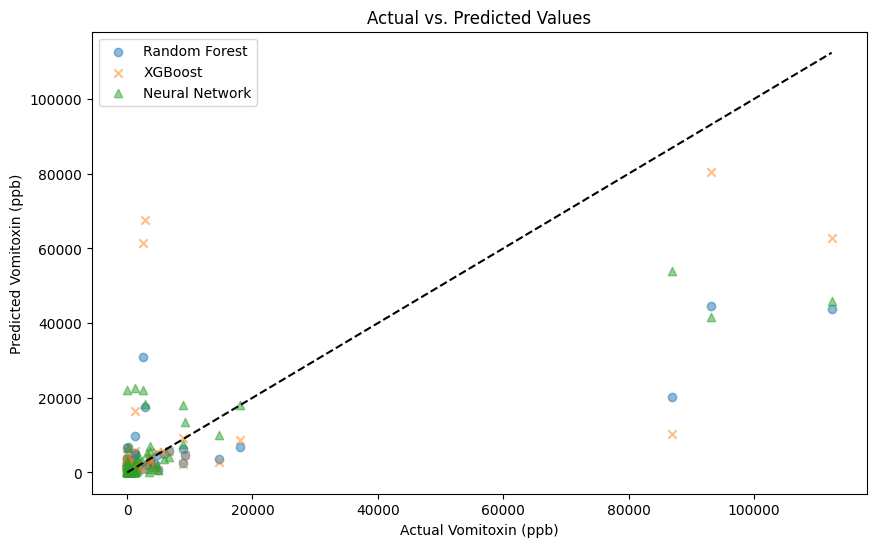

In [ ]:
# --- Visualization of Predictions ---

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label="XGBoost", alpha=0.5, marker='x')
plt.scatter(y_test, y_pred_nn, label="Neural Network", alpha=0.5, marker='^')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='dashed')
plt.xlabel("Actual Vomitoxin (ppb)")
plt.ylabel("Predicted Vomitoxin (ppb)")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.show()